Atividade Individual 2 - *Thyroid Disease Data Set* (Análise de algoritmos de aprendizagem)
======

> **Disciplina**: IN1166 - Soluções de Minerações de Dados <br>
> **Desenvolvedor**: Karl Vandesman de Matos Sousa <br>
> http://github.com/karlvandesman/


## Descrição da atividade
A atividade deve ser executada a partir das bases de dados pré-processadas na primeira atividade individual. Considerando os classificadores vistos em sala de aula K-NN, Árvores de Decisão e Redes Neurais Artificiais MLP, encontrar as melhores configurações para cada base de dados.

Será necessário construir um histórico de configurações de parâmetros de cada classificador com o propósito de apontar qual seria a melhor, com base na acurácia no conjunto de treinamento. São recomendadas no mínimo dez configurações dos parâmetros livres para cada classificador. Um gráfico de evolução da acurácia para cada classificador deve ser apresentado.

Ao final também deverá ser apresentada justificativa da escolha dos melhores parâmetros para cada classificador e o seu desempenho no conjunto de teste.

\* Utilizar o random_state <br>
\** Entregar relatório da atividade via chamada no classroom <br>
\*** Entregar scripts com as melhores configurações de parâmetro para cada classificador <br>

## Introdução

Esta prática trata da aplicação de algoritmos de aprendizagem em um conjunto de dados sobre doença da tireoide (*Thyroid Disease Data Set - UCI Machine Learning Repository*). Na atividade anterior, já se havia trabalhado com esses dados, por meio de análise exploratória e pré-processamento. Dessa forma, partiu-se do código desenvolvido anteriormente para então avaliar o desempenho de três algoritmos de aprendizagem, por meio da acurácia medida.

Antes de entrarmos nos algoritmos de aprendizagem selecionados, é interessante fazer algumas observações acerca da base de dados em que se está lidando. Nesse caso, temos uma base bastante desbalanceada com menos de 10% das observações com resultado positivo (presença da doença). Dessa forma, se o modelo do classificador sempre classificar uma observação como sendo negativa, já teríamos uma acurácia com um valor, a princípio, atraente, maior que 90%. Logo, nesse contexto a acurácia não seria a melhor métrica de desempenho a ser utilizada. Outras opções de métrica poderiam ser o *recall* e a f1 *score*:

$recall = \frac{Verdadeiros positivos (TP)}{Verdadeiros positivos (TP) + Falsos negativos (FN)}$

$f1_{score}= \frac{2 \times precisao \times recall}{precisao+recall}$

Na figura a seguir ([Selecting the Right Metric for Skewed Classification Problems](https://towardsdatascience.com/selecting-the-right-metric-for-skewed-classification-problems-6e0a4a6167a7)) é vista a diferença do resultado das métricas de desempenho aumentando-se o desbalanceamento em um conjunto de dados. Logo, é visto que a acurácia vai aumentando, ao contrário do *recall*, mais adequado pra fazer a medição e se ter uma real dimensão do desempenho do código na base de dados.

![imagem](skewed_data.png)

## Importando bibliotecas

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Algoritmos de aprendizagem
from sklearn import tree
from sklearn import neighbors
from sklearn.neural_network import MLPClassifier

# Grid Search para procura de hiper parâmetros
from sklearn.model_selection import GridSearchCV

## Carregamento do dataset e pré-processamento

In [2]:
# As urls obtidas no site UCI
urlHyper = "https://archive.ics.uci.edu/ml/machine-learning-databases/thyroid-disease/allhyper.data"
urlHypo = "https://archive.ics.uci.edu/ml/machine-learning-databases/thyroid-disease/allhypo.data"

# Passando o nome dos atributos
names = ['age', 'sex', 'on thyroxine', 'query on thyroxine', 'on antithyroid medication', 
         'sick', 'pregnant', 'thyroid surgery', 'I131 treatment', 'query hypothyroid', 
         'query hyperthyroid', 'lithium', 'goitre', 'tumor', 'hypopituitary', 'psych', 
         'TSH measured', 'TSH', 'T3 measured', 'T3', 'TT4 measured', 'TT4', 'T4U measured', 
         'T4U', 'FTI measured', 'FTI', 'TBG measured', 'TBG', 'referral source', "result"]

#Fazendo o carregamento dos dados diretamente do UCI Machine Learning          
dataHyper = pd.read_csv(urlHyper, names=names)
dataHypo = pd.read_csv(urlHypo, names=names)

# Separando o último atributo do valor categórico e numérico
classSeriesHyper = pd.Series(dataHyper['result']) 
classSeriesHypo = pd.Series(dataHypo['result']) 

resultClassHyper = []
resultClassHypo = []

for i in classSeriesHyper:
    a, b = i.split(".|")
    resultClassHyper.append(a)

for i in classSeriesHypo:
    a, b = i.split(".|")
    resultClassHypo.append(a)

dataset = dataHyper.drop(columns=['result'])

dataset['class Hyper'] = resultClassHyper
dataset['class Hypo'] = resultClassHypo

# Como a coluna TBG só possui valores '?', então pode ser descartada
# A coluna TBG measured também, já que só possui valores 'f', então não mais interessa
dataset = dataset.drop(columns=['TBG', 'TBG measured'])

# Substituindo os caracteres ? por NaN
dataset = dataset.replace('?', np.NaN)

# convertendo os dados com NaN para float
dados_continuos = {'age':float, 'TSH':float, 'T3':float, 'TT4':float, 'T4U':float, 'FTI':float}
dataset = dataset.astype(dados_continuos)

# Identificando erros na idade
idade_max = 110
#print(dataset[dataset['age'] > 110])

indice_outliersIdade = dataset.index[dataset['age'] > idade_max]
indice_outliersTSH = dataset.index[dataset['TSH'] > 250]

# Precisamos obter a média de idades sem o outlier
mediaIdade = round((dataset[dataset['age'] < idade_max]).age.mean())
medianaTSH = (dataset[dataset['TSH'] < 250 ]).TSH.median()

#print("Média de idade sem outlier", mediaIdade)
#print("Mediana TSH", medianaTSH)

dataset.loc[indice_outliersIdade, 'age'] = mediaIdade
dataset.loc[indice_outliersTSH, 'TSH'] = medianaTSH

# Abordagens para substituição do NaN
# Após as seguintes substituições, todos os atributos passarão a ter 2800 exemplos válidos (sem NaN)

# Usando a média (mean) ou mediana (median) coluna por coluna
# Somente será substituído o valor para a idade (1 valor) como padrão, o que 
#  não trará relevância na mudança da técnica aplicada 

datasetFull = dataset

# Substituindo o valor de idade pela média (já que não possui muita variação)
datasetFull['age'].fillna((dataset['age']).mean(), inplace=True)
datasetFull['sex'].fillna(method='ffill', inplace=True) # substitui pelo próximo valor

# Substituindo o valor das taxas de hormônio pela mediana ("à prova de outlier")
datasetFull.fillna(dataset.median(), inplace=True)

# É necessário converter os atributos categóricos para valores numéricos para também serem
# considerados na análise do PCA:

#Convertendo dados categóricos para dados numéricos
le = LabelEncoder()
datasetFullNum = datasetFull

for column_name in dataset.columns:
    if datasetFull[column_name].dtype == object:
        datasetFullNum[column_name] = le.fit_transform(datasetFull[column_name])
    else:
        pass

# Primeiramente, devemos normalizar os atributos numéricos que serão considerados
minMaxScaler = MinMaxScaler(feature_range=(0, 1))
X = datasetFullNum.values

XminMax = minMaxScaler.fit_transform(X)

# Subtraindo a média por atributo
XminMaxNorm = XminMax - XminMax.mean(axis = 0)

pca = PCA().fit(XminMaxNorm)

#divisão de dados atributos e classe
X = datasetFull.values[:, 0:-2]
YHyper = dataset.values[:,-1]
YHypo = dataset.values[:,-2]

# Usando o método para fazer uma unica divisão dos dados
XHyper_train, XHyper_test, yHyper_train, yHyper_test = train_test_split(X, YHyper, test_size = 0.25, 
                                                                        random_state = 10)
XHypo_train, XHypo_test, yHypo_train, yHypo_test = train_test_split(X, YHypo, test_size = 0.25, 
                                                                    random_state = 10)

## Aplicação dos algoritmos de aprendizagem

Foram usados os seguintes algoritmos de aprendizagem:
- Árvore de decisao;
- k-Vizinhos mais proximos;
- Redes neurais (MLP - *Multi-Layer Perceptron*).

Em cada um desses algoritmos, foram selecionadas configurações de hiper parâmetros para se testar os melhores resultados de acurácia no conjunto de treino dos dados. Para realizar a buscar da melhor configuração de cada algoritmo, foi utilizada a função [*GridSearchCV()*](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) do sklearn, que faz a combinação de todas as variações de parâmetros selecionados, e a partir da divisão do conjunto de treino em treino e validação (*cross-validation*), obtêm os resultados por tentativa e erro.

Após obtido a configuração com melhor resultado no conjunto de treino, esses parâmetros sao então selecionados para serem usados no conjunto de teste, e então ter-se uma acurácia final do modelo

### 1. Árvore de decisão

Na escolha das configurações, vê-se que a profundidade da árvore foi limitada no segundo caso (Hipotireoidismo). Isso significa que o aumento na altura não implicou na melhoria da divisão dos ramos. Outra implicação é uma melhor visualização dos dados e uma melhor generalização, reduzindo-se a altura, pois uma árvore muito grande significa que o modelo adaptou-se especificamente para um conjunto de dados *overfit*. A divisão sendo a *best* já é esperada, no lugar da aleatória, e o número de *features* considerada para a divisão foi o maior número dentre as opções, o que significa que todos foram importantes para serem considerados na divisão.

In [3]:
paramsArvore = {
        'criterion': ['entropy', 'gini'],
        'splitter': ['random', 'best'],
        'max_depth': [2, 3, 4, 5, 6],
        'max_features': [15, 20, 25],
        'random_state': [10]
        }

clfHyper = GridSearchCV(estimator=tree.DecisionTreeClassifier(), cv=3, 
                        param_grid=paramsArvore, scoring='accuracy', 
                        return_train_score=True)
clfHypo = GridSearchCV(estimator=tree.DecisionTreeClassifier(), cv=3,
                       param_grid=paramsArvore, scoring='accuracy',
                       return_train_score=True)

clfHyper = clfHyper.fit(XHyper_train, yHyper_train)
clfHypo = clfHypo.fit(XHypo_train, yHypo_train)

print()
print("Melhor configuração de parâmetros e sua acurácia (Hipertireoidismo):")
print(clfHyper.best_params_, end=': ')
print(clfHyper.best_score_)
print()

print("Melhor configuração de parâmetros e sua acurácia (Hipotireoidismo):")
print(clfHypo.best_params_, end=': ')
print(clfHypo.best_score_)
print()

''' Apresentar o resultado de todos os classificadores formados
print("Acurácia do grid no desenvolvimento (Hipertireoidismo):")
print()
means = clfHyper.cv_results_['mean_test_score']
stds = clfHyper.cv_results_['std_test_score']
for mean, std, paramsArvore in zip(means, stds, clfHyper.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, paramsArvore))
print()
'''

/home/karlvandesman/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



Melhor configuração de parâmetros e sua acurácia (Hipertireoidismo):
{'criterion': 'entropy', 'max_depth': 6, 'max_features': 25, 'random_state': 10, 'splitter': 'best'}: 0.9928571428571429

Melhor configuração de parâmetros e sua acurácia (Hipotireoidismo):
{'criterion': 'entropy', 'max_depth': 4, 'max_features': 25, 'random_state': 10, 'splitter': 'best'}: 0.9866666666666667



### Visualização dos resultados

Resultado no conjunto de teste (Hiper): 100.0%
Resultado no conjunto de teste (Hipo): 99.57142857142857%


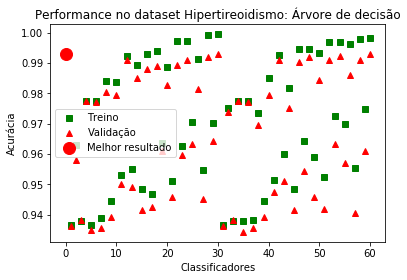

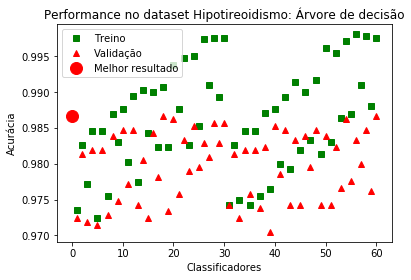

In [4]:
# Visualização dos resultados ----------------------------------

labelX = np.arange(1, len(clfHyper.cv_results_['mean_train_score'])+1, 1)

plt.figure(0)
# Plotar média do conjunto de treino
plt.plot(labelX, clfHyper.cv_results_['mean_train_score'], 'gs', label='Treino')

# Plotar média do conjunto de validação
plt.plot(labelX, clfHyper.cv_results_['mean_test_score'], 'r^', label='Validação')

# Plotar o melhor resultado
plt.plot(clfHyper.best_score_, 'ro', markersize = 12, label='Melhor resultado')

leg = plt.legend(fancybox=True);
plt.xlabel('Classificadores')
plt.ylabel('Acurácia')
plt.title('Performance no dataset Hipertireoidismo: Árvore de decisão')
plt.savefig('Arvore_hiper.png')

plt.figure(1)
# Plotar média do conjunto de treino
plt.plot(labelX, clfHypo.cv_results_['mean_train_score'], 'gs', label='Treino')

# Plotar média do conjunto de validação
plt.plot(labelX, clfHypo.cv_results_['mean_test_score'], 'r^', label='Validação')

# Plotar o melhor resultado
plt.plot(clfHypo.best_score_, 'ro', markersize = 12, label='Melhor resultado')

leg = plt.legend(fancybox=True);
plt.xlabel('Classificadores')
plt.ylabel('Acurácia')
plt.title('Performance no dataset Hipotireoidismo: Árvore de decisão')
plt.savefig('Arvore_hipo.png')

# Uso da melhor configuração para rodar no conjunto de teste
clfHyper = tree.DecisionTreeClassifier(**clfHyper.best_params_)
clfHypo = tree.DecisionTreeClassifier(**clfHypo.best_params_)

clfHyper = clfHyper.fit(XHyper_test, yHyper_test)
clfHypo = clfHypo.fit(XHypo_test, yHypo_test)

print("Resultado no conjunto de teste (Hiper): ", 100*clfHyper.score(XHyper_test, yHyper_test), "%", sep ='')
print("Resultado no conjunto de teste (Hipo): ", 100*clfHypo.score(XHypo_test, yHypo_test), "%", sep='')

### 2. k-Nearest Neighbors (k-Vizinhos mais próximos)

O k-*Nearest Neighbors* ou k-Vizinhos mais próximos, é uma técnica onde não se possui processamneto na fase de treinamento. Os parâmetros variados foram o número *k* de vizinhos, o algoritmo usado para computar os vizinhos, a função peso usada na predição e o tipo de métrica de distância a ser comparada (potência da métrica de Minkowski).

In [5]:
paramsKNN = {
        'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10],
        'algorithm': ['ball_tree', 'kd_tree', 'brute'],
        'weights': ['distance', 'uniform'],
        'p': [1, 2]}

clfHyper = GridSearchCV(estimator=neighbors.KNeighborsClassifier(), cv=3, 
                        param_grid=paramsKNN, scoring='accuracy', 
                        return_train_score=True)
clfHypo = GridSearchCV(estimator=neighbors.KNeighborsClassifier(), cv=3,
                       param_grid=paramsKNN, scoring='accuracy',
                       return_train_score=True)

clfHyper = clfHyper.fit(XHyper_train, yHyper_train)
clfHypo = clfHypo.fit(XHypo_train, yHypo_train)

print()
print("Melhor configuração de parâmetros e sua acurácia (Hipertireoidismo):")
print(clfHyper.best_params_, end=': ')
print(clfHyper.best_score_)
print()

print("Melhor configuração de parâmetros e sua acurácia (Hipotireoidismo):")
print(clfHypo.best_params_, end=': ')
print(clfHypo.best_score_)
print()

#print("Acurácia do grid no desenvolvimento (Hipertireoidismo):")
#print()
#means = clfHyper.cv_results_['mean_test_score']
#stds = clfHyper.cv_results_['std_test_score']
#for mean, std, paramsKNN in zip(means, stds, clfHyper.cv_results_['params']):
#    print("%0.3f (+/-%0.03f) for %r"
#          % (mean, std * 2, paramsKNN))
#print()

/home/karlvandesman/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



Melhor configuração de parâmetros e sua acurácia (Hipertireoidismo):
{'algorithm': 'ball_tree', 'n_neighbors': 3, 'p': 2, 'weights': 'distance'}: 0.9495238095238095

Melhor configuração de parâmetros e sua acurácia (Hipotireoidismo):
{'algorithm': 'ball_tree', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}: 0.9795238095238096



### Visualização dos resultados

O algoritmo ajustou-se com valores baixos no número de vizinhos, com 3 e 5. Vale notar que se não fosse feito a divisão do treino para o conjunto de validação, simplesmente considerando-se a acurácia no conjunto de treino obteria-se acurácia maior quanto menor for o  \textit{k}. Nesse contexto entra a importância de um conjunto de validação para o modelo ser menos enviesado.

Resultado no conjunto de teste (Hiper): 100.0%
Resultado no conjunto de teste (Hipo): 100.0%


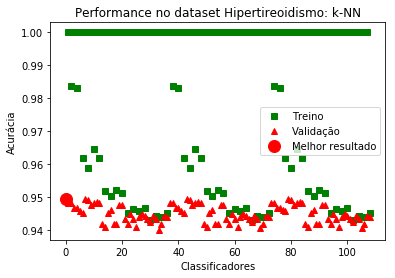

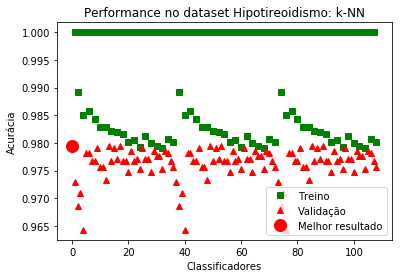

In [6]:
labelX = np.arange(1, len(clfHyper.cv_results_['mean_train_score'])+1, 1)

plt.figure(0)
# Plotar média do conjunto de treino
plt.plot(labelX, clfHyper.cv_results_['mean_train_score'], 'gs', label='Treino')

# Plotar média do conjunto de validação
plt.plot(labelX, clfHyper.cv_results_['mean_test_score'], 'r^', label='Validação')

# Plotar o melhor resultado
plt.plot(clfHyper.best_score_, 'ro', markersize = 12, label='Melhor resultado')

leg = plt.legend(fancybox=True);
plt.xlabel('Classificadores')
plt.ylabel('Acurácia')
plt.title('Performance no dataset Hipertireoidismo: k-NN')
plt.savefig('kNN_hiper.png')

plt.figure(1)
# Plotar média do conjunto de treino
plt.plot(labelX, clfHypo.cv_results_['mean_train_score'], 'gs', label='Treino')

# Plotar média do conjunto de validação
plt.plot(labelX, clfHypo.cv_results_['mean_test_score'], 'r^', label='Validação')

# Plotar o melhor resultado
plt.plot(clfHypo.best_score_, 'ro', markersize = 12, label='Melhor resultado')

leg = plt.legend(fancybox=True);
plt.xlabel('Classificadores')
plt.ylabel('Acurácia')
plt.title('Performance no dataset Hipotireoidismo: k-NN')
plt.savefig('kNN_hipo.png')

# Uso da melhor configuração para rodar no conjunto de teste
clfHyper = neighbors.KNeighborsClassifier(**clfHyper.best_params_)
clfHypo = neighbors.KNeighborsClassifier(**clfHypo.best_params_)

clfHyper = clfHyper.fit(XHyper_test, yHyper_test)
clfHypo = clfHypo.fit(XHypo_test, yHypo_test)

print("Resultado no conjunto de teste (Hiper): ", 100*clfHyper.score(XHyper_test, yHyper_test), "%", sep ='')
print("Resultado no conjunto de teste (Hipo): ", 100*clfHypo.score(XHypo_test, yHypo_test), "%", sep='')

### 3. Redes Neurais (MLP)

Diferente da árvore de decisão e do k-NN, na rede neural temos maior possibilidade de variação de parâmetros, devido a complexidade da arquitetura de uma rede neural. Aqui existem várias possibilidades de formato da rede, de regularização que pode resolver problemas de *overfitting*, velocidade de aprendizado, e de forma de ativação do neurônio. Um dos parâmetros que mais influenciam a resposta é a função de ativação, e como *default* temos a *ReLU*. A arquitetura da rede também influcenciará bastante.

In [7]:
paramsMLP = {
        'hidden_layer_sizes': [[(10)], (3, 3)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'lbfgs', 'sgd'],
        'alpha': [0.01, 0.1, 1, 10],
        'learning_rate_init': [0.1, 1],
        'max_iter': [200],
        'random_state': [10]}

clfHyper = GridSearchCV(estimator=MLPClassifier(), cv=3, 
                        param_grid=paramsMLP, scoring='accuracy', 
                        return_train_score=True)
clfHypo = GridSearchCV(estimator=MLPClassifier(), cv=3,
                       param_grid=paramsMLP, scoring='accuracy',
                       return_train_score=True)

clfHyper = clfHyper.fit(XHyper_train, yHyper_train)
clfHypo = clfHypo.fit(XHypo_train, yHypo_train)

print()
print("Melhor configuração de parâmetros e sua acurácia (Hipertireoidismo):")
print(clfHyper.best_params_, end=': ')
print(clfHyper.best_score_)
print()

print("Melhor configuração de parâmetros e sua acurácia (Hipotireoidismo):")
print(clfHypo.best_params_, end=': ')
print(clfHypo.best_score_)
print()

#print("Acurácia do grid no desenvolvimento (Hipertireoidismo):")
#print()
#means = clfHyper.cv_results_['mean_test_score']
#stds = clfHyper.cv_results_['std_test_score']
#for mean, std, paramsMLP in zip(means, stds, clfHyper.cv_results_['params']):
#    print("%0.3f (+/-%0.03f) for %r"
#          % (mean, std * 2, paramsMLP))
#print()

/home/karlvandesman/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
/home/karlvandesman/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/karlvandesman/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/karlvandesman/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations


Melhor configuração de parâmetros e sua acurácia (Hipertireoidismo):
{'activation': 'tanh', 'alpha': 1, 'hidden_layer_sizes': (3, 3), 'learning_rate_init': 0.1, 'max_iter': 200, 'random_state': 10, 'solver': 'lbfgs'}: 0.9680952380952381

Melhor configuração de parâmetros e sua acurácia (Hipotireoidismo):
{'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': [10], 'learning_rate_init': 0.1, 'max_iter': 200, 'random_state': 10, 'solver': 'lbfgs'}: 0.9814285714285714



/home/karlvandesman/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### Visualização dos resultados

A justificativa para a configuração da arquitetura em uma rede neural é mais complexa, pois esta funciona como uma caixa preta. O melhor valor para o parâmetro de taxa de aprendizado é obtido por tentativa e erro. Já o *alpha*, pode-se ter alguma previsão pois ele é o que estará penalizando, servindo como termo de regularização. Ou seja, se o modelo está com *overfitting*, aumenta-se a regularização para suavização e melhor ajuste do modelo.

Resultado no conjunto de teste (Hiper): 95.14285714285714%
Resultado no conjunto de teste (Hipo): 99.0%


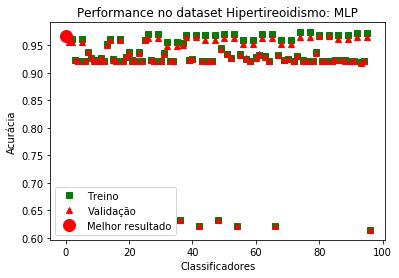

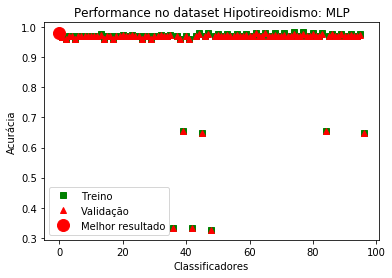

In [8]:
# Visualização dos resultados ----------------------------------

labelX = np.arange(1, len(clfHyper.cv_results_['mean_train_score'])+1, 1)

plt.figure(0)
# Plotar média do conjunto de treino
plt.plot(labelX, clfHyper.cv_results_['mean_train_score'], 'gs', label='Treino')

# Plotar média do conjunto de validação
plt.plot(labelX, clfHyper.cv_results_['mean_test_score'], 'r^', label='Validação')

# Plotar o melhor resultado
plt.plot(clfHyper.best_score_, 'ro', markersize = 12, label='Melhor resultado')

leg = plt.legend(fancybox=True);
plt.xlabel('Classificadores')
plt.ylabel('Acurácia')
plt.title('Performance no dataset Hipertireoidismo: MLP')
plt.savefig('MLP_hiper.png')

plt.figure(1)
# Plotar média do conjunto de treino
plt.plot(labelX, clfHypo.cv_results_['mean_train_score'], 'gs', label='Treino')

# Plotar média do conjunto de validação
plt.plot(labelX, clfHypo.cv_results_['mean_test_score'], 'r^', label='Validação')

# Plotar o melhor resultado
plt.plot(clfHypo.best_score_, 'ro', markersize = 12, label='Melhor resultado')

leg = plt.legend(fancybox=True);
plt.xlabel('Classificadores')
plt.ylabel('Acurácia')
plt.title('Performance no dataset Hipotireoidismo: MLP')
plt.savefig('MLP_hipo.png')

# Uso da melhor configuração para rodar no conjunto de teste
clfHyper = MLPClassifier(**clfHyper.best_params_)
clfHypo = MLPClassifier(**clfHypo.best_params_)

clfHyper = clfHyper.fit(XHyper_test, yHyper_test)
clfHypo = clfHypo.fit(XHypo_test, yHypo_test)

print("Resultado no conjunto de teste (Hiper): ", 100*clfHyper.score(XHyper_test, yHyper_test), "%", sep ='')
print("Resultado no conjunto de teste (Hipo): ", 100*clfHypo.score(XHypo_test, yHypo_test), "%", sep='')

## Conclusão

Como descrito anteriormente, a dificuldade na avaliação dos algoritmos de aprendizagem está no mal uso da métrica de acurácia para uma base de dados bastante desbalanceada. Nesse contexto, tem-se um resultado facilmente chegando próximo de 100%, mesmo com grande variação dos parâmetros.
    
Outra questão está na divisão do conjunto de treino para validação cruzada na função *GridSearchCV()*. Como algumas classes possuem poucas observações (a menor possui somente um), o próprio algoritmo gera um aviso de que o número de divisões é maior que o número de exemplares de alguma classe. Isso gera conjuntos de separação onde não há representação da classe, sendo portanto, impossível para o classificador prever aquela classe no conjunto de validação.